In [ ]:
#@title Importing
!nvidia-smi
!pip install -q matplotlib
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install -q timm
!pip install -q opencv-python
!pip install -q dalle2_pytorch==0.15.4
!git clone https://github.com/lucidrains/DALLE2-pytorch.git
import shutil
import torch
import os
import importlib
import numpy as np
import sys
import os
import json
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, OpenAIClipAdapter, train_configs
from dalle2_pytorch.tokenizer import tokenizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Wed Aug 10 07:40:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Version list
decoder_versions = [{
    "name": "Original",
    "dalle2_install_path": "git+https://github.com/Veldrovive/DALLE2-pytorch@f4b687798d367fc434d8127ab31141f0fea0db26",
    "decoder_path": "https://huggingface.co/Veldrovive/DA-VINC-E/resolve/main/text_conditioned_epoch_34.pth",
    "config_path": "https://huggingface.co/Veldrovive/DA-VINC-E/raw/main/text_conditioned_config.json"
},{
    "name": "New 1B (Aesthetic)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/small_32gpus/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/small_32gpus/decoder_config.json"
},{
    "name": "New 1.5B (Aesthetic)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/1.5B/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/1.5B/decoder_config.json"
},{
    "name": "New 1.5B (Laion2B)",
    "dalle2_install_path": "dalle2_pytorch==0.15.4",
    "decoder_path": "https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/decoder/1.5B_laion2B/latest.pth",
    "config_path": "https://huggingface.co/laion/DALLE2-PyTorch/raw/main/decoder/1.5B_laion2B/decoder_config.json"
}]
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)
current_state = {
            "text_input": '',
            "text_repeat": 3,
            "prior_conditioning": 1.0,
            "img_repeat": 1,
            "decoder_conditioning": 3.5,
            "include_prompt_checkbox": True,
            "upsample_checkbox": True,
            "decoder": decoder_versions[-1], #pick one from decoder_versions
            #the following need to type the local path
            "model_paths": {
                "decoder": os.path.join(model_dir, "decoder.pth"),
                "decoder_config": os.path.join(model_dir, "decoder_config.json"),
                "prior": os.path.join(model_dir, "prior.pth"),
                "prior_config": None
            }
        }

In [ ]:
#@title Model choice
#@markdown 0 for Original 

#@markdown 1 for New 1B (Aesthetic) 

#@markdown 2 for New 1.5B (Aesthetic)

#@markdown 3 for New 1.5B (Laion2B)
version = 3 #@param {type:"integer"}

In [ ]:
#@title Download
#Downloading
decoder_url = decoder_versions[version]["decoder_path"]
decoder_config_url = decoder_versions[version]["config_path"]
prior_url = "https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/prior_aes_finetune.pth"
decoder_path = current_state["model_paths"]["decoder"]
decoder_config_path = current_state["model_paths"]["decoder_config"]
prior_path = current_state["model_paths"]["prior"]
!curl -L {decoder_url} > {decoder_path}
!curl -L {decoder_config_url} > {decoder_config_path}
!curl -L {prior_url} > {prior_path}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   267  100   267    0     0   6846      0 --:--:-- --:--:-- --:--:--  6846
100 4736M  100 4736M    0     0  46.5M      0  0:01:41  0:01:41 --:--:-- 46.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2983  100  2983    0     0  59660      0 --:--:-- --:--:-- --:--:-- 59660
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   279  100   279    0     0   7971      0 --:--:-- --:--:-- --:--:--  7971
100 5582M  100 5582M    0     0   237M      0  0:00:23  0:00:23 --:--:--  222M


In [ ]:
#@title setup
#Decoder
def conditioned_on_text(config):
    try:
        return config.decoder.unets[0].cond_on_text_encodings
    except AttributeError:
        pass
    
    try:
        return config.decoder.condition_on_text_encodings
    except AttributeError:
        pass
    
    return False

decoder_text_conditioned = False
clip_config = None
def load_decoder(decoder_state_dict_path, config_file_path):
  config = train_configs.TrainDecoderConfig.from_json_path(config_file_path)
  global decoder_text_conditioned
  decoder_text_conditioned = conditioned_on_text(config)
  global clip_config
  clip_config = config.decoder.clip
  config.decoder.clip = None
  print("Decoder conditioned on text", decoder_text_conditioned)
  decoder = config.decoder.create().to(device)
  decoder_state_dict = torch.load(decoder_state_dict_path, map_location='cpu')
  decoder.load_state_dict(decoder_state_dict, strict=False)
  del decoder_state_dict
  decoder.eval()
  return decoder
decoder = load_decoder(current_state["model_paths"]["decoder"], current_state["model_paths"]["decoder_config"])
#Prior

def load_prior(model_path):
  prior_network = DiffusionPriorNetwork(
    dim=768,
    depth=24,
    dim_head=64,
    heads=32,
    normformer=True,
    attn_dropout=5e-2,
    ff_dropout=5e-2,
    num_time_embeds=1,
    num_image_embeds=1,
    num_text_embeds=1,
    num_timesteps=1000,
    ff_mult=4
  )

  diffusion_prior = DiffusionPrior(
    net=prior_network,
    clip=OpenAIClipAdapter("ViT-L/14"),
    image_embed_dim=768,
    timesteps=1000,
    cond_drop_prob=0.1,
    loss_type="l2",
    condition_on_text_encodings=True,
  ).to(device)

  state_dict = torch.load(model_path, map_location='cpu')
  
  if 'ema_model' in state_dict:
    print('Loading EMA Model')
    diffusion_prior.load_state_dict(state_dict['ema_model'], strict=True)
  else:
    print('Loading Standard Model')
    diffusion_prior.load_state_dict(state_dict['model'], strict=False)
  del state_dict
  return diffusion_prior
diffusion_prior = load_prior(current_state["model_paths"]["prior"])
#Clip
clip = None
if clip_config is not None:
  clip = clip_config.create()
from PIL import Image, ImageDraw, ImageFont

class ImageText(object):
    def __init__(self, filename_or_size, mode='RGBA', background=(0, 0, 0, 0), encoding='utf8'):
        if isinstance(filename_or_size, str):
            self.filename = filename_or_size
            self.image = Image.open(self.filename)
            self.size = self.image.size
        elif isinstance(filename_or_size, (list, tuple)):
            self.size = filename_or_size
            self.image = Image.new(mode, self.size, color=background)
            self.filename = None
        self.draw = ImageDraw.Draw(self.image)
        self.encoding = encoding

    def save(self, filename=None):
        self.image.save(filename or self.filename)

    def get_font_size(self, text, font, max_width=None, max_height=None):
        if max_width is None and max_height is None:
            raise ValueError('You need to pass max_width or max_height')
        font_size = 1
        text_size = self.get_text_size(font, font_size, text)
        if (max_width is not None and text_size[0] > max_width) or \
           (max_height is not None and text_size[1] > max_height):
            raise ValueError("Text can't be filled in only (%dpx, %dpx)" % \
                    text_size)
        while True:
            if (max_width is not None and text_size[0] >= max_width) or \
               (max_height is not None and text_size[1] >= max_height):
                return font_size - 1
            font_size += 1
            text_size = self.get_text_size(font, font_size, text)

    def write_text(self, xy, text, font_filename, font_size=11,
                   color=(0, 0, 0), max_width=None, max_height=None):
        x, y = xy
        # if isinstance(text, str):
        #     text = text.decode(self.encoding)
        if font_size == 'fill' and \
           (max_width is not None or max_height is not None):
            font_size = self.get_font_size(text, font_filename, max_width,
                                           max_height)
        text_size = self.get_text_size(font_filename, font_size, text)
        font = ImageFont.truetype(font_filename, font_size)
        # font = ImageFont.load_default()
        if x == 'center':
            x = (self.size[0] - text_size[0]) / 2
        if y == 'center':
            y = (self.size[1] - text_size[1]) / 2
        self.draw.text((x, y), text, font=font, fill=color)
        return text_size

    def get_text_size(self, font_filename, font_size, text):
        font = ImageFont.truetype(font_filename, font_size)
        return font.getsize(text)

    def write_text_box(self, xy, text, box_width, font_filename,
                       font_size=11, color=(0, 0, 0), place='left',
                       justify_last_line=False):
        x, y = xy
        lines = []
        line = []
        words = text.split()
        for word in words:
            new_line = ' '.join(line + [word])
            size = self.get_text_size(font_filename, font_size, new_line)
            text_height = size[1]
            if size[0] <= box_width:
                line.append(word)
            else:
                lines.append(line)
                line = [word]
        if line:
            lines.append(line)
        lines = [' '.join(line) for line in lines if line]
        height = y
        for index, line in enumerate(lines):
            if place == 'left':
                self.write_text((x, height), line, font_filename, font_size,
                                color)
            elif place == 'right':
                total_size = self.get_text_size(font_filename, font_size, line)
                x_left = x + box_width - total_size[0]
                self.write_text((x_left, height), line, font_filename,
                                font_size, color)
            elif place == 'center':
                total_size = self.get_text_size(font_filename, font_size, line)
                x_left = int(x + ((box_width - total_size[0]) / 2))
                self.write_text((x_left, height), line, font_filename,
                                font_size, color)
            elif place == 'justify':
                words = line.split()
                if (index == len(lines) - 1 and not justify_last_line) or \
                   len(words) == 1:
                    self.write_text((x, height), line, font_filename, font_size,
                                    color)
                    continue
                line_without_spaces = ''.join(words)
                total_size = self.get_text_size(font_filename, font_size,
                                                line_without_spaces)
                space_width = (box_width - total_size[0]) / (len(words) - 1.0)
                start_x = x
                for word in words[:-1]:
                    self.write_text((start_x, height), word, font_filename,
                                    font_size, color)
                    word_size = self.get_text_size(font_filename, font_size,
                                                    word)
                    start_x += word_size[0] + space_width
                last_word_size = self.get_text_size(font_filename, font_size,
                                                    words[-1])
                last_word_x = x + box_width - last_word_size[0]
                self.write_text((last_word_x, height), words[-1], font_filename,
                                font_size, color)
            height += text_height
        return (box_width, height - y)

def download_font():
  if not os.path.exists("./Arial.ttf"):
    !wget https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
  return "./Arial.ttf"


def map_images(np_images, prior_repeat, decoder_repeat, prompts, upscale=4):
  # Match the images to their prompts
  # Format [{ prompt: STRING, images: [
  #  { prior_index: INT, decoder_index: INT, img: NP_ARR[64, 64, 3] }
  # ] }]
  image_map = {}
  curr_index = 0
  for prompt in prompts:
    for prior_index in range(prior_repeat):
      for decoder_index in range(decoder_repeat):
        img = np_images[curr_index]
        if prompt not in image_map:
          image_map[prompt] = []
        if isinstance(img, np.ndarray):
          image = Image.fromarray(np.uint8(img * 255))
          image = image.resize([dim * upscale for dim in image.size])
        else:
          image = img
        image_map[prompt].append({
            "prior_index": prior_index,
            "decoder_index": decoder_index,
            "img": image
        })
        curr_index += 1
  return image_map

def format_image_grid(img_array):
  example_image = img_array[0]["img"]
  max_prior_index = max((inst["prior_index"] for inst in img_array))
  cols = max_prior_index + 1
  max_decoder_index = max((inst["decoder_index"] for inst in img_array))
  rows = max_decoder_index + 1

  w, h = example_image.size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for img_data in img_array:
    x_pos = img_data["prior_index"] * w
    y_pos = img_data["decoder_index"] * h
    grid.paste(img_data["img"], box=(x_pos, y_pos))
  return grid

def format_prompt_image(prompt, grid_img, font_size=20, horizontal_padding=10, vertical_padding=10):
  grid_w, grid_h = grid_img.size
  prompt_img = ImageText((grid_w, 2000), background=(255, 255, 255, 255))
  # font = ImageFont.load("arial.pil")
  # font = ImageFont.load_default()
  font_path = download_font()
  text_w, text_h = prompt_img.write_text_box((horizontal_padding, vertical_padding), prompt, box_width=grid_w - horizontal_padding, font_filename=font_path, font_size=font_size, color=(0, 0, 0), place='center')
  text_img = prompt_img.image
  text_img = text_img.crop((0, 0, grid_w, text_h + 2*vertical_padding))
  full_img = Image.new('RGB', (grid_w, text_img.size[1] + grid_h))
  full_img.paste(text_img, (0, 0))
  full_img.paste(grid_img, (0, text_img.size[1]))
  return full_img

def save_images(output_dir, np_images):
  os.makedirs(output_dir, exist_ok=True)
  for i, np_img in enumerate(np_images):
    image = Image.fromarray(np.uint8(np_img * 255))
    output_path = os.path.join(output_dir, f'{i}.png')
    image.save(output_path)

def upscale_dir(input_dir):
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq {input_dir} --scale 4 --large_model
  results_dir = "./results/swinir_real_sr_x4_large"
  output_files = sorted([file for file in os.listdir(results_dir) if '.png' in file], key=lambda e: int(e.split('_')[0]))
  upscale_dims = (256, 256, 3)
  images = [None] * len(output_files)
  for i, filename in enumerate(output_files):
    pil_img = Image.open(os.path.join(results_dir, filename))
    images[i] = pil_img
#   shutil.rmtree(results_dir)
  !rm {results_dir}
  return images


Decoder conditioned on text True


100%|███████████████████████████████████████| 933M/933M [00:18<00:00, 49.3MiB/s]


Loading EMA Model


Output()

Running prior


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Running decoder
Generating clip embeddings


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

downloading model experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Testing 0 0                   
Testing 1 1                   
Testing 2 2                   
rm: cannot remove './results/swinir_real_sr_x4_large': Is a directory
--2022-08-10 08:02:42--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2022-08-10 08:02:42--  https://raw.githubuserconten

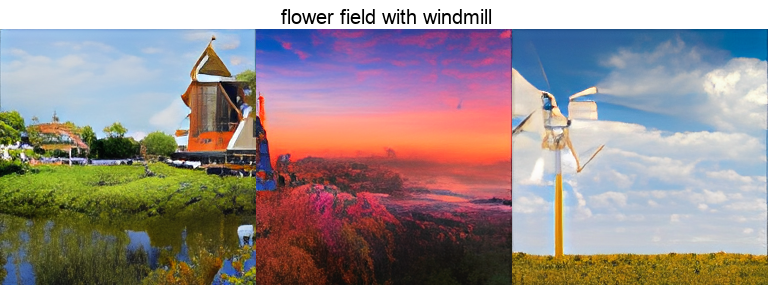

Button(description='Download', style=ButtonStyle())

In [ ]:
#@title Input prompts (you should run it before type the prompts, and click the Start button)
!pip install -q ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact
try:
  from google.colab import files
  can_download = True
except ImportError:
  can_download = False

text_input = widgets.Textarea(
    placeholder='Prompts separated by new lines...',
    value=str(current_state["text_input"]),
    disabled=False,
    continuous_update=True,
    layout={'width': 'auto'},
    rows=10
)
textbox_box = widgets.VBox([text_input], layout={'border': '2px solid grey'})

prior_label = widgets.HTML(value="<b>Prior Options:</b> Set how many sample to take from the prior and what conditioning scale to use.")
text_repeat = widgets.IntSlider(
    value=int(current_state["text_repeat"]),
    min=1,
    max=10,
    step=1,
    description='Text Repeat',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)

prior_conditioning = widgets.FloatSlider(
    value=float(current_state["prior_conditioning"]),
    min=0.0,
    max=10.0,
    step=0.1,
    description='Prior Cond Scale',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)
prior_options_box = widgets.VBox([prior_label, text_repeat, prior_conditioning], layout=widgets.Layout(border="2px solid grey", padding="5px 10px", flex="1 0 auto"))

decoder_label = widgets.HTML(value="<b>Decoder Options:</b> Set how many sample to take from the decoder and what conditioning scale to use.")
img_repeat = widgets.IntSlider(
    value=int(current_state["img_repeat"]),
    min=1,
    max=10,
    step=1,
    description='Img Repeat',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)

decoder_conditioning = widgets.FloatSlider(
    value=float(current_state["decoder_conditioning"]),
    min=0.0,
    max=10.0,
    step=0.1,
    description='Decoder Cond Scale',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="100%")
)
decoder_options_box = widgets.VBox([decoder_label, img_repeat, decoder_conditioning], layout=widgets.Layout(border="2px solid grey", padding="5px 10px", flex="1 0 auto"))
main_options_box = widgets.HBox([prior_options_box, decoder_options_box], layout=widgets.Layout(width="100%"))

include_prompt_checkbox = widgets.Checkbox(
    value=bool(current_state["include_prompt_checkbox"]),
    description='Show prompt in output image',
    disabled=False,
    indent=False
)

upsample_checkbox = widgets.Checkbox(
    value=bool(current_state['upsample_checkbox']),
    description = 'Upsample to 256x256 with SwinIR',
    disabled=False,
    indent=False
)

meta_options_box = widgets.VBox([include_prompt_checkbox, upsample_checkbox])

button = widgets.Button(
    description="Start"
)
final_options_box = widgets.HBox([meta_options_box, button], layout=widgets.Layout(justify_content="space-between", border="2px solid grey", padding="10px 30px"))

main_layout = widgets.VBox([textbox_box, main_options_box, final_options_box])

def get_prompts():
  import json
  text = text_input.value
  try:
    prompts_array = json.loads(text)
    assert isinstance(prompts_array, list)
    return prompts_array
  except Exception as e:
#     print("Failed to read as json", e)
    pass
  
  try:
    return list(filter(lambda v: len(v) > 0, text.split("\n")))
  except Exception as e:
    print("Failed to read as text with newlines", e)
  
  return []

def f(text_input, text_repeat, prior_conditioning, img_repeat, decoder_conditioning, include_prompt_checkbox, upsample_checkbox):
  prompts = get_prompts()
  total_images = len(prompts) * text_repeat * img_repeat

  global current_state
  current_state = {
      **current_state,
      "text_input": text_input,
      "text_repeat": text_repeat,
      "prior_conditioning": prior_conditioning,
      "img_repeat": img_repeat,
      "decoder_conditioning": decoder_conditioning,
      "include_prompt_checkbox": include_prompt_checkbox,
      "upsample_checkbox": upsample_checkbox,
  }

  output_strings = []
  output_strings.append(f"Using model: {current_state['decoder']['name']}")
  output_strings.append(f"Total output images: {total_images}")
  output_strings.append("")
  output_strings.extend([f"Prompt {index}: {prompt}" for index, prompt in enumerate(prompts)])
  output_strings.append("")
  output_strings.append("Including prompt text in output image" if include_prompt_checkbox else "Not including prompt text in output image")
  output_strings.append(f"Prior Conditioning Scale: {prior_conditioning}")
  output_strings.append(f"Decoder Conditioning Scale: {decoder_conditioning}")
  print('\n'.join(output_strings))

out = widgets.interactive_output(f, {'text_input': text_input, 'text_repeat': text_repeat, 'prior_conditioning': prior_conditioning, 'img_repeat': img_repeat, 'decoder_conditioning': decoder_conditioning, 'include_prompt_checkbox': include_prompt_checkbox, 'upsample_checkbox': upsample_checkbox })

display(main_layout, out)

def on_start(_, recall_embeddings=False, recall_images=False):
  if os.path.exists("./output"):
    shutil.rmtree("./output")
  clear_output()
  display(main_layout, out)
  prompts = get_prompts()
  prior_cond_scale = prior_conditioning.value
  decoder_cond_scale = decoder_conditioning.value
  text_rep = text_repeat.value
  img_rep = img_repeat.value
  include_prompt = include_prompt_checkbox.value
  upsample = upsample_checkbox.value
  
  prior_text_input = []
  for prompt in prompts:
    for _ in range(text_rep):
      prior_text_input.append(prompt)
  
  tokens = tokenizer.tokenize(prior_text_input).to(device)
  if recall_embeddings:
    print("Loading embeddings")
    image_embed = np.load('img_emb_prior.npy')
  else:
    print("Running prior")
    with torch.no_grad():
      image_embed = diffusion_prior.sample(tokens, cond_scale = prior_cond_scale).cpu().numpy()
    np.save('img_emb_prior.npy', image_embed)

  embeddings = np.repeat(image_embed, img_rep, axis=0)
  embeddings = torch.from_numpy(embeddings).float().to(device)
  if recall_images:
    print("Loading images")
    images = np.load('images_decoder.npy')
  else:
    print("Running decoder")
    with torch.no_grad():
      if decoder_text_conditioned:
        print("Generating clip embeddings")
        _, text_encoding, text_mask = clip.embed_text(tokens)
        images = decoder.sample(embeddings, text_encodings = text_encoding, text_mask = text_mask, cond_scale = decoder_cond_scale)
      else:
        print("Not generating clip embeddings")
        images = decoder.sample(embeddings, text = None, cond_scale = decoder_cond_scale)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    np.save('images_decoder.npy', images)

  if upsample:
    save_images('output/images', images)
    images = upscale_dir('output/images')

  img_map = map_images(images, text_rep, img_rep, prompts, upscale=4)
  for index, (prompt, imgs) in enumerate(img_map.items()):
    img = format_image_grid(imgs)
    if include_prompt:
      img = format_prompt_image(prompt, img, font_size=20, horizontal_padding=5, vertical_padding=5)
    display(img)
    if can_download:
      download_button = widgets.Button(
        description="Download"
      )
      display(download_button)
      download_button.on_click(lambda b: files.download(f"./output/example_{index}.png"))
    os.makedirs("./output", exist_ok=True)
    img.save(f"./output/example_{index}.png")

button.on_click(on_start)